In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy as sp
import scipy.interpolate
import scipy.signal
import scipy.stats

from PIL import Image
import scipy.io
from sklearn.preprocessing import normalize
import numpy.ma as ma
import math

from PIL import ImageFilter
from matplotlib import cm

In [3]:
def filelist(ID):
    return {'mask':"masks/ventricle_masks/mask"+str(ID)+"IDS.txt",
           'blowout':"masks/blowout_masks/mask"+str(ID)+"IDS_blowout.txt"}

def generate_mask(files, snr_mask):
    mask = {}
    mask['mask'] = np.loadtxt(files['mask'])
    mask['blowout_mask'] = np.loadtxt(files['blowout'])
    mask['snr_mask'] = snr_mask
    res = np.logical_and(~mask["blowout_mask"].astype(bool), mask['mask'])
    res = np.logical_and(res, mask["snr_mask"])
    return res

In [4]:
def load_recordings(filelist, CL_list):
    data = [CL_list, {}]
    for i, CL in enumerate(CL_list):
        data[1][CL] = sp.io.loadmat(filelist[i])
        data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
        width = data[1][CL]['cmosData'].shape[0] #get width
        height = data[1][CL]['cmosData'].shape[1] #get height
        data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    return data

def supersample(cmosData, fps, target_fps):
    length = cmosData.shape[2]
    end_time = int(np.round((length * 1000/fps)))
    time_n = int(end_time) + 1
    time_series = np.linspace(0, end_time, length)
    x = np.linspace(0, int(end_time), time_n)
    signal = sp.interpolate.interp1d(time_series, cmosData, axis = 2)
    return signal(x)

def ens_avg(cmosData, CL, cutoff):
    h = cmosData.shape[0]
    w = cmosData.shape[1]
    x = cmosData[:,:,cutoff:]
    center_point = (h//2, w//2)
    first_depol = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL]))
    res = np.zeros([200,200,CL])
    N = x.shape[2]//CL
    for i in range(N):
        shift = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL])) - first_depol
        #print(shift)
        shift = 0
        res += np.roll(x[:,:,i*CL:(i+1)*CL], -shift, axis = 2)
    res = res/N
    return res

def condition(data, cutoffs, corruption, CL, ens_avg_flag = True, sigma = 1.2):
    #data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
    width = data[1][CL].shape[0] #get width
    height = data[1][CL].shape[1] #get height
    #data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    data[1][CL][np.isnan(data[1][CL])]=0
    data[1][CL] = scipy.ndimage.gaussian_filter(data[1][CL],(sigma, sigma ,0), truncate = 2.0)
    data[1][CL] = supersample(data[1][CL], data[1]["frequency"], 1000)
    data[1][CL] = data[1][CL][:,:,:corruption[CL]]
    length = data[1][CL].shape[2] #?
    if ens_avg_flag:
        data[1][CL] = ens_avg(data[1][CL], CL, cutoffs[CL])
        length = CL
    smooth = scipy.ndimage.gaussian_filter(data[1][CL], (0,0,7))
    data[1][CL] = data[1][CL] - np.tile(np.reshape(smooth.min(axis = 2), (width, height, 1)), (1,1,length))
    data[1][CL] = np.divide(data[1][CL], np.tile(np.reshape(data[1][CL].max(axis = 2), (width, height, 1)), (1,1,length)), out=np.zeros_like(data[1][CL]), where=data[1][CL]!=0)
        
def APD80_map(data, CL):
    width = data.shape[0]
    height = data.shape[1]
    APD80 = np.zeros_like(data[:,:,0])
    time = np.linspace(0, CL-1, CL)
    for i in range(width):
        for j in range(height):
            if np.isnan(data[i,j,1]) or np.max(data[i,j,:]) < 0.2:
                APD80[i,j] = float('nan')
            else:
                if np.diff(np.where(data[i,j,:] <0.2)).size:
                    APD80[i,j] = np.max(np.diff(np.where(data[i,j,:] < 0.2)))
    return APD80

def apply_mask(data, mask):
    for CL in data[0]:
        mask = np.where(mask==0, float('nan'), mask)
        expanded_mask = np.repeat(np.expand_dims(mask, axis = 2), data[1][CL].shape[2], axis = 2)
        data[1][CL] = np.multiply(data[1][CL], expanded_mask)

def ventricle_mask(filename):
    mask_png = Image.open(filename)
    mask_array = np.array(mask_png)
    mask = mask_array[:,:,3] > 0.0
    return mask

In [11]:
#4AP:

CL_list_heart40 = [150, 140, 130, 120]
filelist_heart40 = ["data/mouse_40_150ms_4AP_iDS.mat",
                    "data/mouse_40_140ms_4AP_iDS.mat",
                    "data/mouse_40_130ms_4AP_iDS.mat",
                    "data/mouse_40_120ms_4AP_iDS.mat"]

CL_list_heart41 = [150]
filelist_heart41 = ["data/mouse_41_150ms_4AP_iDS.mat"]

CL_list_heart45 = [150, 140, 130, 120]
filelist_heart45 = ["data/mouse_45_150ms_4AP_iDS.mat",
                    "data/mouse_45_140ms_4AP_iDS.mat",
                    "data/mouse_45_130ms_4AP_iDS.mat",
                    "data/mouse_45_120ms_4AP_iDS.mat"]

CL_list_heart46 = [150, 140, 130, 120]
filelist_heart46 = ["data/mouse_46_150ms_4AP_iDS.mat",
                    "data/mouse_46_140ms_4AP_iDS.mat",
                    "data/mouse_46_130ms_4AP_iDS.mat",
                    "data/mouse_46_120ms_4AP_iDS.mat"]

CL_list_heart31 = [150]
filelist_heart31 = ["data/mouse_31_150ms_4AP_iDS.mat"]

CL_list_heart62 = [150]
filelist_heart62 = ["data/mouse_62_150ms_4AP_iDS.mat"]

In [ ]:
#4AP
heart40 = load_recordings(filelist_heart40, CL_list_heart40)
#frame = heart31[1][150]['cmosData'][:,:,0]
apply_mask(heart40, generate_mask(filelist(40), np.loadtxt("./snr_maps/4AP/IDS/SNR40.csv")>0.2))
heart40_cutoffs = {150:0, 140:35, 130:90, 120:40}
heart40_corruption = {150:None, 140:None, 130:None, 120:None}
for CL in CL_list_heart40[::-1]:
    condition(heart40, heart40_cutoffs, heart40_corruption, CL)
    apply_mask(heart40, generate_mask(filelist(40), np.loadtxt("./snr_maps/4AP/IDS/SNR40.csv")>0.2))
#     plt.plot(heart40[1][CL][100, 100, :])
#     plt.show()
    apdmap = APD80_map(heart40[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/4AP/IDS/SNR40.csv")>0.2)

    RV_mask = ventricle_mask("masks/RV_masks/heart40_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart40_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    apdmap[apdmap < 10] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

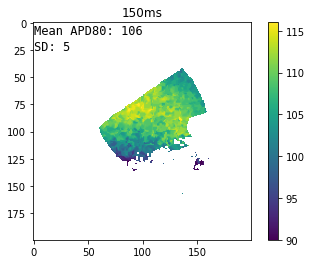

In [25]:
apdmap = APD80_map(heart41[1][CL], CL)
apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/4AP/IDS/SNR41.csv")>0.6)
apdmap = np.multiply(apdmap, np.loadtxt("mask_41_no_electrode.txt"))

#     RV_mask = ventricle_mask("masks/RV_masks/heart41_iDS_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
# LV_mask = ventricle_mask("masks/LV_masks/heart41_iDS_LV.png")
# apdmap = np.multiply(apdmap, LV_mask)
LV_mask_1 = ventricle_mask("heart41_shifted_LV.png")
apdmap = np.multiply(apdmap, LV_mask_1)
apdmap[apdmap == 0] = np.nan

iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

plt.figure()
plt.imshow(apdmap)
plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
plt.title("%dms"%CL)
plt.colorbar()
plt.show()

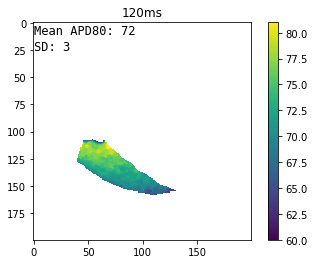

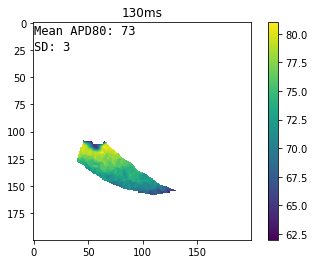

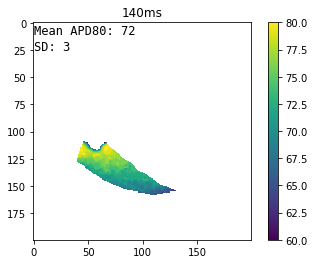

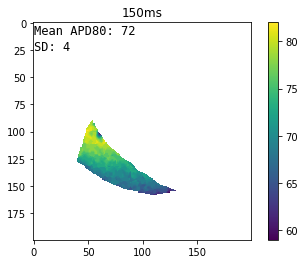

In [23]:
#4AP
heart45 = load_recordings(filelist_heart45, CL_list_heart45)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/4AP/IDS/SNR45.csv")>0.3))
heart45_cutoffs = {150:100, 140:50, 130:10, 120:30}
heart45_corruption = {150:None, 140:None, 130:None, 120:None}
for CL in CL_list_heart45[::-1]:
    condition(heart45, heart45_cutoffs, heart45_corruption, CL)
    apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/4AP/IDS/SNR45.csv")>0.3))
#     plt.plot(heart45[1][CL][100, 100, :])
#     plt.show()
    apdmap = APD80_map(heart45[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/4AP/IDS/SNR45.csv")>0.4)

    RV_mask = ventricle_mask("masks/RV_masks/heart45_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart45_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

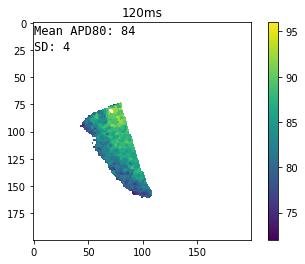

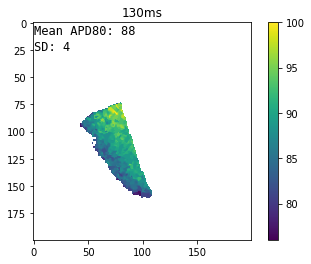

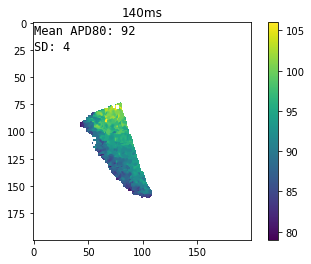

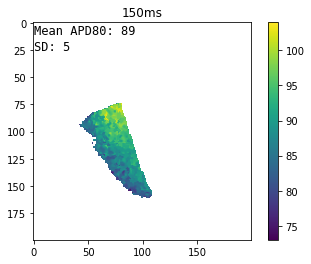

In [20]:
#4AP
heart46 = load_recordings(filelist_heart46, CL_list_heart46)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/4AP/IDS/SNR46.csv")>0.3))
heart46_cutoffs = {150:120, 140:100, 130:50, 120:0}
heart46_corruption = {150:None, 140:None, 130:None, 120:None}
for CL in CL_list_heart46[::-1]:
    apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/4AP/IDS/SNR46.csv")>0.3))
    condition(heart46, heart46_cutoffs, heart46_corruption, CL)
#     plt.plot(heart46[1][CL][100, 100, :])
#     plt.show()
    apdmap = APD80_map(heart46[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/4AP/IDS/SNR46.csv")>0.4)

    RV_mask = ventricle_mask("masks/RV_masks/heart46_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart46_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

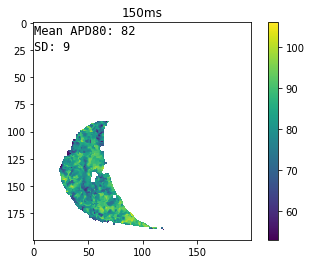

In [21]:
#4AP
heart62 = load_recordings(filelist_heart62, CL_list_heart62)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart62, generate_mask(filelist(62), np.loadtxt("./snr_maps/4AP/IDS/SNR62.csv")>0.1))
heart62_cutoffs = {150:0}
heart62_corruption = {150:None}
for CL in CL_list_heart62:
    condition(heart62, heart62_cutoffs, heart62_corruption, CL)
#     plt.plot(heart62[1][CL][100, 100, :])
#     plt.show()
    apdmap = APD80_map(heart62[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/4AP/IDS/SNR62.csv")>0.1)

    RV_mask = ventricle_mask("masks/RV_masks/heart62_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart62_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

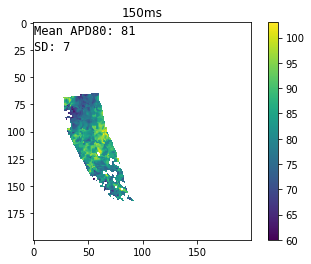

In [22]:
heart31 = load_recordings(filelist_heart31, CL_list_heart31)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3))
heart31_cutoffs = {150:80}
heart31_corruption = {150:None}
for CL in CL_list_heart31[::-1]:
    condition(heart31, heart31_cutoffs, heart31_corruption, CL)
    apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3))
    apdmap = APD80_map(heart31[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3)

    RV_mask = ventricle_mask("masks/RV_masks/heart31_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart31_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()